In [1]:
import collections

import numpy as np
import pandas as pd

# Visualisation
from pprint import pprint
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
# from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn import tree

# Save model
import pickle

In [2]:
def diff(li1, li2):
    '''
    This function returns different elements between 2 lists
    '''
    return (list(set(li1) - set(li2)))

def plot_stats(df, feature, target_ftr, label_rotation=False, horizontal_layout=True):
    '''
    This function plot the categorical feature distribution according to target variable
    '''
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of repaid-loans': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, target_ftr]].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by=target_ftr, ascending=False, inplace=True)

    sns.set_color_codes("pastel")
    s = sns.barplot(x = feature, y="Number of repaid-loans",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=60)

    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();


def get_rocauc(model, xTest, yTest):
    '''
    This function produces the Area under the curve for the model.
    The 'auto' method calculates this metric by using the roc_auc_score function from sklearn.
    Range: 0 to 1 (0 being the worst predictive model, 0.5 being the random and 1 being the best)
    '''
    predictions = model.predict_proba(xTest)[:, 1]
    roc_auc = roc_auc_score(yTest, predictions)
    print('Model Performance:')
    print('--'*5)
    print('--'*5)
    print('ROC = {:0.2f}%'.format(roc_auc))

    return roc_auc

def plot_roc(yTest, yPred):
    '''
    This function plots the ROC and gives the AUC.
    Range for Area under the curve : 0 to 1 (0 being the worst and 1 being best for predictive model)
    '''
    fpr, tpr, thresholds = roc_curve(yTest, yPred)
    roc_auc = roc_auc_score(yTest, yPred)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='random')
    plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def perf_measure(y_actual, y_pred):
    '''
    Function for calculating TP, FP, TN and FN
    '''
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)

def capture_curve(test_df, y_test, preds, roc, title):
    '''
    Function for to plot capture curve for risky or non-repaid loans
    This is similar to gain and lift chart in statistics.
    x-axis: Population % of granted loans
    y-axis: Risk / Non-repaid loan %
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    rate = []
    for i in threshold:
        T = perf_measure(list(y_test),[1 if j >= i else 0 for j in preds])
        rate.append(T[0]+T[1])
    rate2 = [i/len(test_df) for i in rate]
    plt.figure(figsize=[12,12])
    plt.plot(rate2, tpr, label='ROC_AUC {}'.format(roc) % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Granted Loans', fontsize=18)
    plt.ylabel('Captured out of total non-repaid proportion', fontsize=18)
    plt.title('Capture plot for {}'.format(title), fontsize=18)
    plt.legend(loc="lower right",prop={'size':30})
    plt.show()

def decile_cutoff_risk_detected(df_pred):
    '''
    Function to find the decile-wise risky loan application %
    '''
    pop_perc = list(np.arange(0.1,1.1,0.1))
    perc_list = []
    risk_perc_list = []
    risk_num_list = []
    avg_pred_prob_list = []
    min_pred_prob_list = []
    max_pred_prob_list = []
    df_pop_risk = pd.DataFrame(columns=['loan_percentage','non-repaid_percentage', '#non-repaid_loans', 'avg_pred_prob'])
    total_risk_count = df_pred[df_pred['loan_quality']==1]['loan_id'].count()
    start = 0
    for perc in pop_perc:
        split_len = int(perc*len(df_pred))
        sorted_results_final = df_pred.iloc[start:split_len]
        risk_count = sorted_results_final[sorted_results_final['loan_quality']==1]['loan_id'].count()
        min_pred_prob = sorted_results_final['preds'].min()
        max_pred_prob = sorted_results_final['preds'].max()
        avg_pred_prob = sorted_results_final['preds'].mean()
        perc_list.append(int(perc*100))
        risk_perc_list.append(round(((risk_count/total_risk_count)*100),2))
        risk_num_list.append(round(risk_count,2))
        min_pred_prob_list.append(round(min_pred_prob, 2))
        max_pred_prob_list.append(round(max_pred_prob, 2))
        avg_pred_prob_list.append(round(avg_pred_prob, 2))
        start = split_len
    df_pop_risk['loan_percentage'] = perc_list
    df_pop_risk['non-repaid_percentage'] = risk_perc_list
    df_pop_risk['#non-repaid_loans'] = risk_num_list
    df_pop_risk['min_pred_prob'] = min_pred_prob_list
    df_pop_risk['max_pred_prob'] = max_pred_prob_list
    df_pop_risk['avg_pred_prob'] = avg_pred_prob_list
    return df_pop_risk

def cum_decile_cutoff_risk_detected(df_pred):
    '''
    Function to find the decile-wise risky loan application %
    '''
    pop_perc = list(np.arange(0.1,1.1,0.1))
    perc_list = []
    risk_perc_list = []
    risk_num_list = []
    avg_pred_prob_list = []
    min_pred_prob_list = []
    max_pred_prob_list = []
    df_pop_risk = pd.DataFrame(columns=['loan_percentage','non-repaid_percentage', '#non-repaid_loans', 'avg_pred_prob'])
    total_risk_count = df_pred[df_pred['loan_quality']==1]['loan_id'].count()
    for perc in pop_perc:
        split_len = int(perc*len(df_pred))
        sorted_results_final = df_pred.iloc[:split_len]
        risk_count = sorted_results_final[sorted_results_final['loan_quality']==1]['loan_id'].count()
        min_pred_prob = sorted_results_final['preds'].min()
        max_pred_prob = sorted_results_final['preds'].max()
        avg_pred_prob = sorted_results_final['preds'].mean()
        perc_list.append(int(perc*100))
        risk_perc_list.append(round(((risk_count/total_risk_count)*100),2))
        risk_num_list.append(round(risk_count,2))
        min_pred_prob_list.append(round(min_pred_prob, 2))
        max_pred_prob_list.append(round(max_pred_prob, 2))
        avg_pred_prob_list.append(round(avg_pred_prob, 2))
    df_pop_risk['loan_percentage'] = perc_list
    df_pop_risk['non-repaid_percentage'] = risk_perc_list
    df_pop_risk['#non-repaid_loans'] = risk_num_list
    df_pop_risk['min_pred_prob'] = min_pred_prob_list
    df_pop_risk['max_pred_prob'] = max_pred_prob_list
    df_pop_risk['avg_pred_prob'] = avg_pred_prob_list
    return df_pop_risk

def profitability_diff(score1_name, score2_name, score1, score2):
    '''
    This function takes 2 scores as input and gives Absolute Difference between scores as output
    '''
    if score1 > score2:
        print('%s is %d point better than %s' % (score1_name, abs(score1 - score2), score2_name))
        print('--'*30)
        print('%s is %f times better than %s' % (score1_name, (score1/score2), score2_name))
    else:
        print('%s is %d point better than %s' % (score2_name, abs(score1 - score2), score1_name))
        print('--'*30)
        print('%s is %f times better than %s' % (score2_name, (score2/score1), score1_name))

In [3]:
borrower=pd.read_csv(r'C:\Users\ZhongLee\Downloads\fid\borrower_table.csv')
# check dimensions of the dataset, we found it has 307,511 rows and 122 columns
borrower.shape
borrower.head(3)

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8


In [4]:
loan=pd.read_csv(r'C:\Users\ZhongLee\Downloads\fid\loan_table.csv')
# check dimensions of the dataset, we found it has 307,511 rows and 122 columns
loan.shape
loan.head(3)

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN


## **Exploratory Data Analysis (EDA)**

In [5]:
# Merge Dataframes
df_loan = loan.merge(borrower, how='left', on='loan_id')

print(df_loan.shape)
df_loan.head(3)

(101100, 16)


,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4


In [6]:
loan.columns.to_list()

['loan_id', 'loan_purpose', 'date', 'loan_granted', 'loan_repaid']

In [7]:
loan.shape

(101100, 5)

In [8]:
borrower.shape

(101100, 12)

In [9]:
loan.loan_id.nunique()

101100

In [10]:
borrower.loan_id.nunique()

101100

In [11]:
print(f'There are {loan.shape[0] - loan.loan_id.nunique()} duplicates for loan id in the loan table')
print(f'There are {borrower.shape[0] - borrower.loan_id.nunique()} duplicates for loan id in the borrower table')

There are 0 duplicates for loan id in the loan table
There are 0 duplicates for loan id in the borrower table


In [12]:
#loan_id comparison
borrower_loan_id = list(borrower['loan_id'])
loan_loan_id = list(loan['loan_id'])

if collections.Counter(borrower_loan_id) == collections.Counter(loan_loan_id):
    print ("All the loan ids comparison are same")
else :
    print ("Different loan ids are present in both the datasets")

All the loan ids comparison are same


In [13]:
#This function returns different elements between 2 lists
def diff(li1, li2):

    return (list(set(li1) - set(li2)))

#Cross check with set difference option
print(diff(borrower_loan_id, loan_loan_id))

[]


In [14]:
# Merge Dataframes
df_loan = loan.merge(borrower, how='left', on='loan_id')

print(df_loan.shape)
df_loan.head(3)

(101100, 16)


,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4


In [15]:
# get the Simple Summary Statistics
df_loan.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_id,101100.0,499666.826726,288662.006929,30.0,250333.75,499885.00,749706.25,999987.00
loan_granted,101100.0,0.471355,0.499181,0.0,0.00,0.00,1.00,1.00
loan_repaid,47654.0,0.644353,0.478714,0.0,0.00,1.00,1.00,1.00
is_first_loan,101100.0,0.543492,0.498107,0.0,0.00,1.00,1.00,1.00
fully_repaid_previous_loans,46153.0,0.899291,0.300946,0.0,1.00,1.00,1.00,1.00
currently_repaying_other_loans,46153.0,0.364332,0.481247,0.0,0.00,0.00,1.00,1.00
total_credit_card_limit,101100.0,4112.743818,2129.121462,0.0,2700.00,4100.00,5500.00,13500.00
avg_percentage_credit_card_limit_used_last_year,94128.0,0.724140,0.186483,0.0,0.60,0.73,0.86,1.09
saving_amount,101100.0,1799.617616,1400.545141,0.0,834.00,1339.00,2409.00,10641.00
checking_amount,101100.0,3177.150821,2044.448155,0.0,1706.00,2673.00,4241.00,13906.00


In [16]:
print(df_loan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   loan_purpose                                     101100 non-null  object 
 2   date                                             101100 non-null  object 
 3   loan_granted                                     101100 non-null  int64  
 4   loan_repaid                                      47654 non-null   float64
 5   is_first_loan                                    101100 non-null  int64  
 6   fully_repaid_previous_loans                      46153 non-null   float64
 7   currently_repaying_other_loans                   46153 non-null   float64
 8   total_credit_card_limit                          101100 non-null  int64  
 9   avg_percentage_

In [17]:
df_loan.dtypes
type_counts = df_loan.dtypes.value_counts()
print(type_counts)

int64      10
float64     4
object      2
Name: count, dtype: int64


In [18]:
object_dtypes = df_loan.select_dtypes(include=['object']).dtypes
print(object_dtypes)

loan_purpose    object
date            object
dtype: object


In [19]:
numerical_dtypes = df_loan.select_dtypes(include=['number']).dtypes
print(numerical_dtypes)

loan_id                                              int64
loan_granted                                         int64
loan_repaid                                        float64
is_first_loan                                        int64
fully_repaid_previous_loans                        float64
currently_repaying_other_loans                     float64
total_credit_card_limit                              int64
avg_percentage_credit_card_limit_used_last_year    float64
saving_amount                                        int64
checking_amount                                      int64
is_employed                                          int64
yearly_salary                                        int64
age                                                  int64
dependent_number                                     int64
dtype: object


['loan_repaid', 'fully_repaid_previous_loans', 'currently_repaying_other_loans']


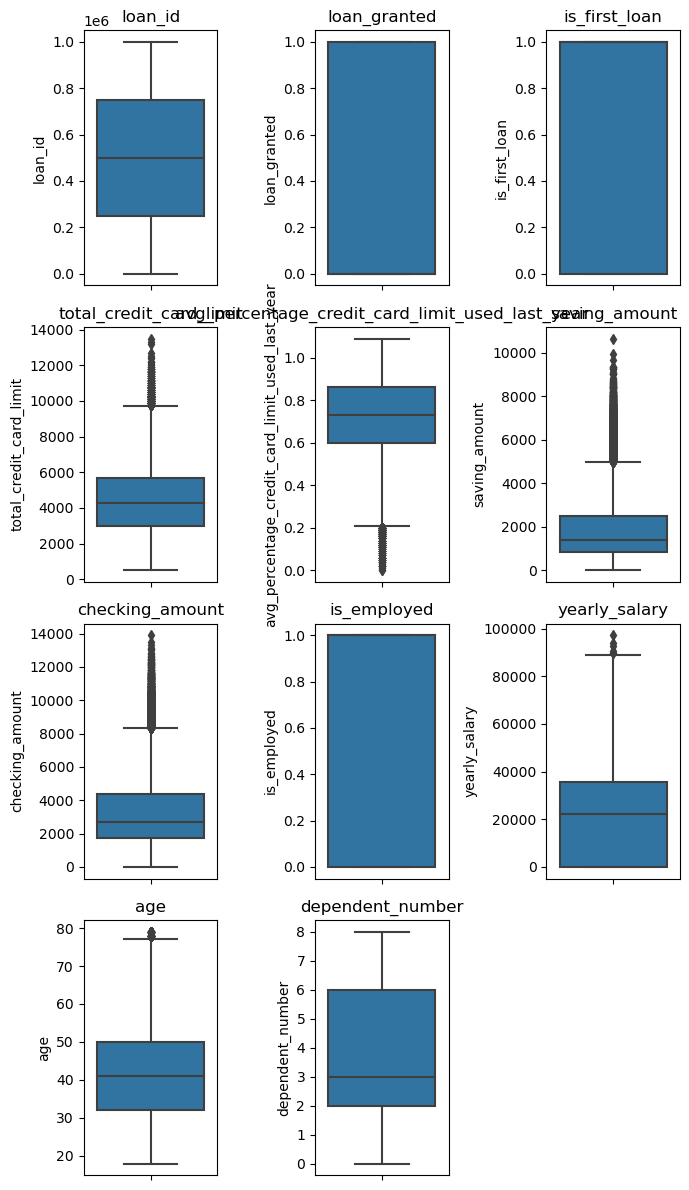

In [20]:
# Calculate the percentage of missing values for each column
missing_percentage = (df_loan.isnull().sum() / len(df_loan)) * 100

# Get columns with missing percentage greater than 20%
columns_to_drop = missing_percentage[missing_percentage > 20].index.tolist()

# Drop specified columns
outlier_df = df_loan.drop(columns_to_drop, axis=1)
print(columns_to_drop)

# Filter rows with no null values in any column
outlier_df = outlier_df.dropna()

# Check if remaining columns are numeric
numeric_columns = outlier_df.select_dtypes(include=['number']).columns

# Visualization
num_columns = len(numeric_columns)
num_rows = math.ceil(num_columns / 3)
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7, 3*num_rows))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(y=outlier_df[column], ax=axes[i])
    axes[i].set_title(column)

for j in range(num_columns, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

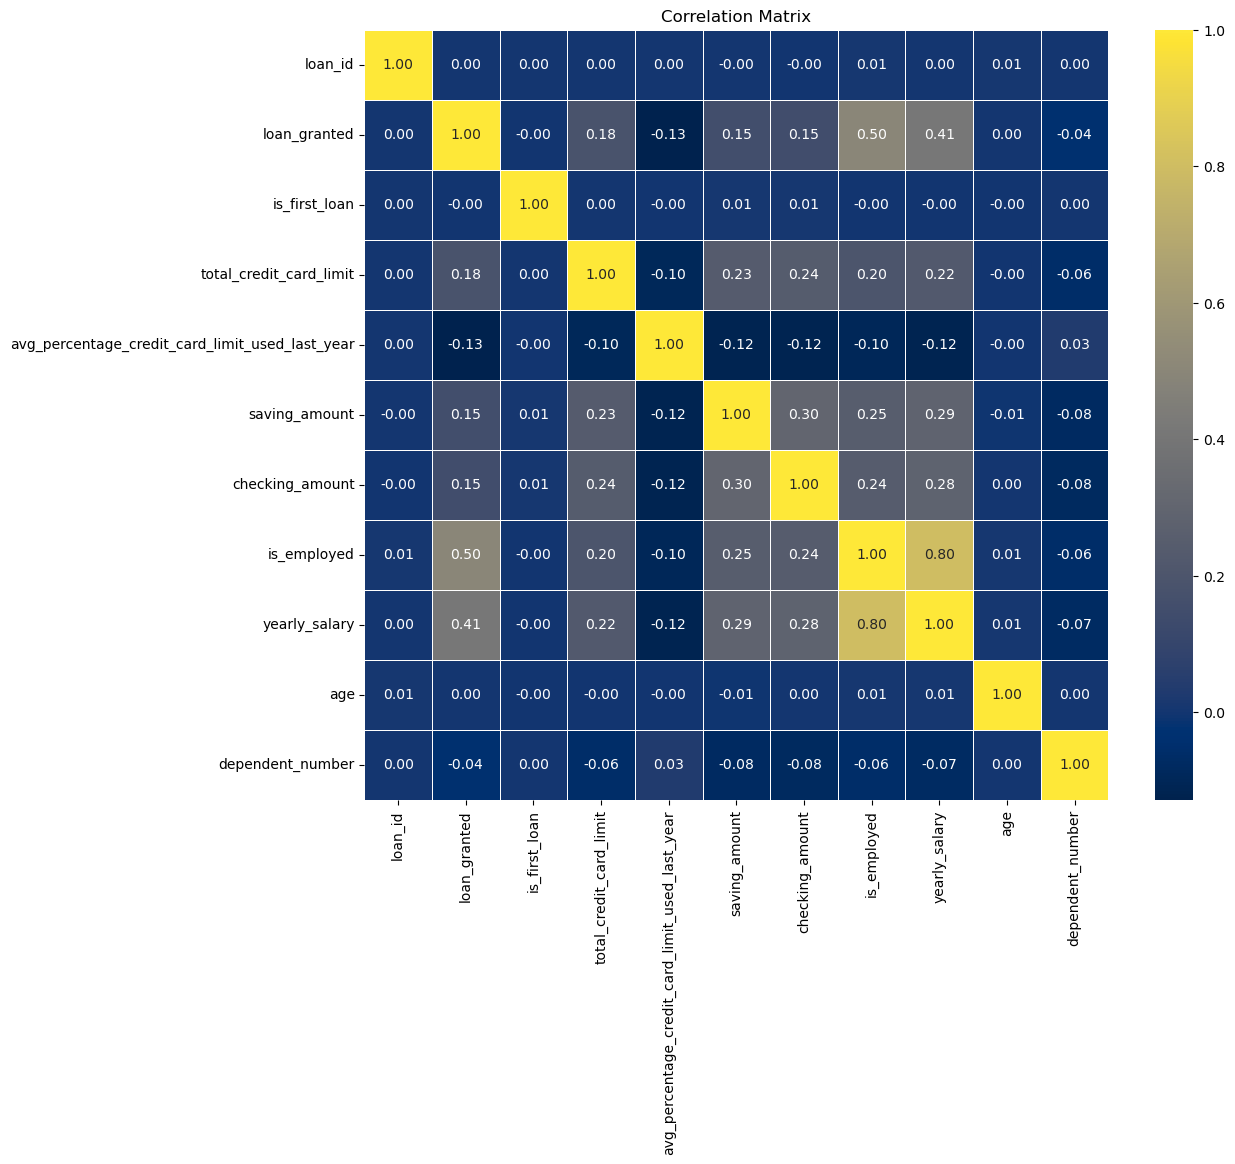

In [21]:
# Drop specified columns
# Calculate the percentage of missing values for each column
missing_percentage = (df_loan.isnull().sum() / len(df_loan)) * 100

# Get columns with missing percentage greater than 20%
columns_to_drop = missing_percentage[missing_percentage > 20].index.tolist()

# Filter rows with no null values in any column
outlier_df = outlier_df.dropna()
corr_df = df_loan.drop(columns_to_drop, axis=1)

# Remove non-numeric columns for correlation computation
numeric_cols = corr_df.select_dtypes(include=['number']).columns
correlation_matrix = corr_df[numeric_cols].corr()

# Plot correlation heatmap with adjusted figsize
plt.figure(figsize=(12, 10))  # Adjusted figsize
sns.heatmap(correlation_matrix, annot=True, cmap="cividis", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [22]:
#Create different datasets for granted & ungranted and repaid & non-repaid segments

granted   = df_loan.loc[(df_loan['loan_granted'] == 1)]
ungranted = df_loan.loc[(df_loan['loan_granted'] == 0)]

repaid     = granted.loc[(granted['loan_repaid'] == 1)]
non_repaid = granted.loc[(granted['loan_repaid'] == 0)]

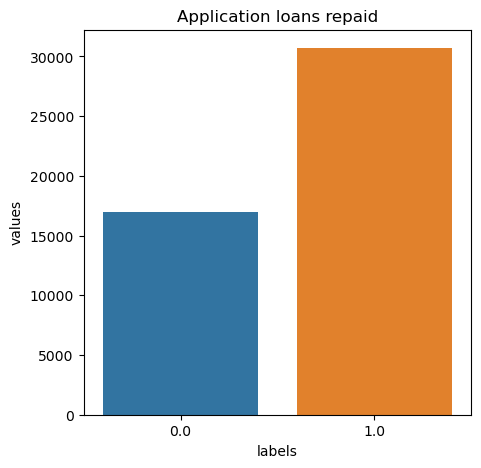

In [23]:
# Class Imbalance check

temp_ln_rpd = granted['loan_repaid'].value_counts()
df_ln_rpd = pd.DataFrame({'labels': temp_ln_rpd.index,
                   'values': temp_ln_rpd.values})
plt.figure(figsize = (5,5))
plt.title('Application loans repaid')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df_ln_rpd)
locs, labels = plt.xticks()
plt.show()

In [24]:
def plot_stats(df, feature, target_ftr, label_rotation=False, horizontal_layout=True):
    '''
    This function plot the categorical feature distribution according to target variable
    '''
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of repaid-loans': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, target_ftr]].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by=target_ftr, ascending=False, inplace=True)

    sns.set_color_codes("pastel")
    s = sns.barplot(x = feature, y="Number of repaid-loans",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=60)

    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

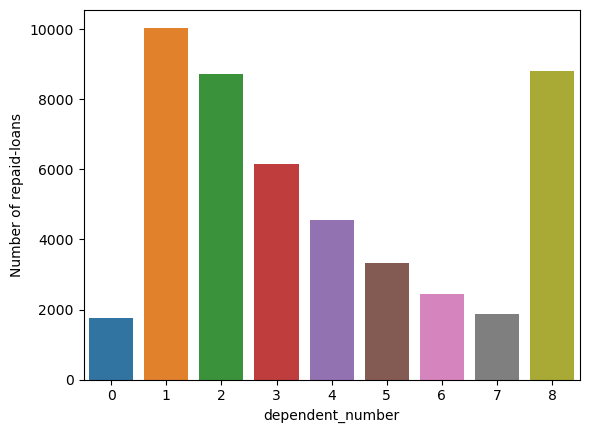

In [25]:
plot_stats(granted, 'dependent_number', 'loan_repaid', label_rotation=False, horizontal_layout=True)

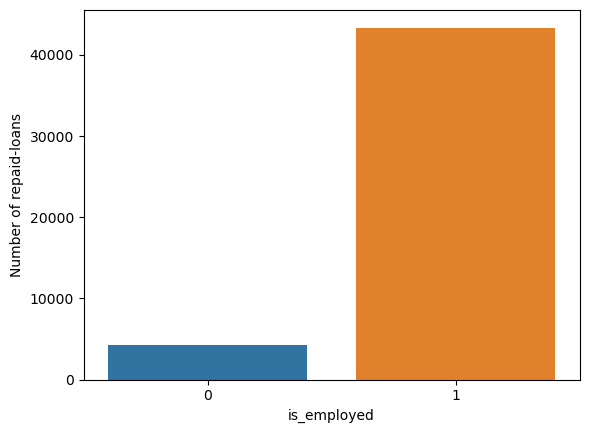

In [26]:
plot_stats(granted, 'is_employed', 'loan_repaid', label_rotation=False, horizontal_layout=True)

In [27]:
# How many of employed repay their loans
print('Employed who repay their loans (%) :')
print(round(((granted[(granted['is_employed']==1) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['is_employed']==1)].shape[0])*100,1))

print('')
print('')

# How many of un-employed repay their loans
print('Unemployed who repay their loans (%) :')
print(round(((granted[(granted['is_employed']==0) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['is_employed']==0)].shape[0])*100,1))

Employed who repay their loans (%) :
69.0


Unemployed who repay their loans (%) :
17.9


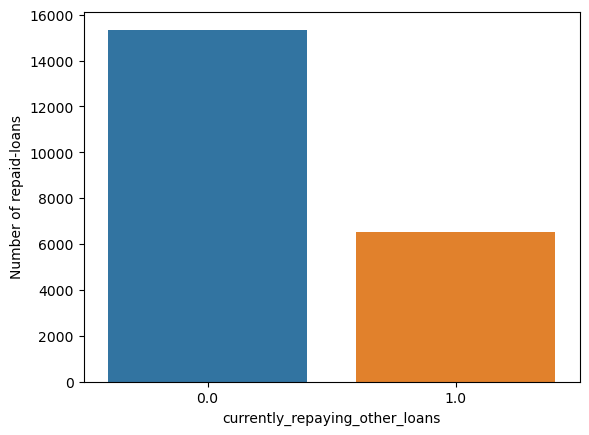

In [28]:
plot_stats(granted, 'currently_repaying_other_loans', 'loan_repaid', label_rotation=False, horizontal_layout=True)

In [29]:
# How many repay the loan while paying for another loan
print('People who repay their loans having existing loan payment (%) :')
print(round(((granted[(granted['currently_repaying_other_loans']==1) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['currently_repaying_other_loans']==1)].shape[0])*100,2))

print('')
print('')

# How many repay the loan when not paying for other loans
print('People who repay their loans not having any other loan payment (%) :')
print(round(((granted[(granted['currently_repaying_other_loans']==0) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['currently_repaying_other_loans']==0)].shape[0])*100,2))

People who repay their loans having existing loan payment (%) :
27.13


People who repay their loans not having any other loan payment (%) :
79.3


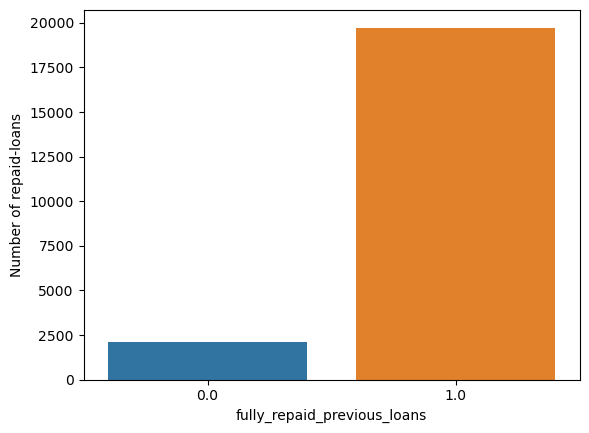

In [30]:
plot_stats(granted, 'fully_repaid_previous_loans', 'loan_repaid', label_rotation=False, horizontal_layout=True)

In [31]:
# How many of people repay their loans who have fully repaid previous loans
print('People who repay their loans who have fully repaid previous loans (%) :')
print(round(((granted[(granted['fully_repaid_previous_loans']==1) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['fully_repaid_previous_loans']==1)].shape[0])*100,2))

print('')
print('')

# How many of people repay their loans who haven't fully repaid previous loans
print('People who repay their loans who have not fully repaid previous loans (%) :')
print(round(((granted[(granted['fully_repaid_previous_loans']==0) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['fully_repaid_previous_loans']==0)].shape[0])*100,2))

People who repay their loans who have fully repaid previous loans (%) :
64.38


People who repay their loans who have not fully repaid previous loans (%) :
58.11


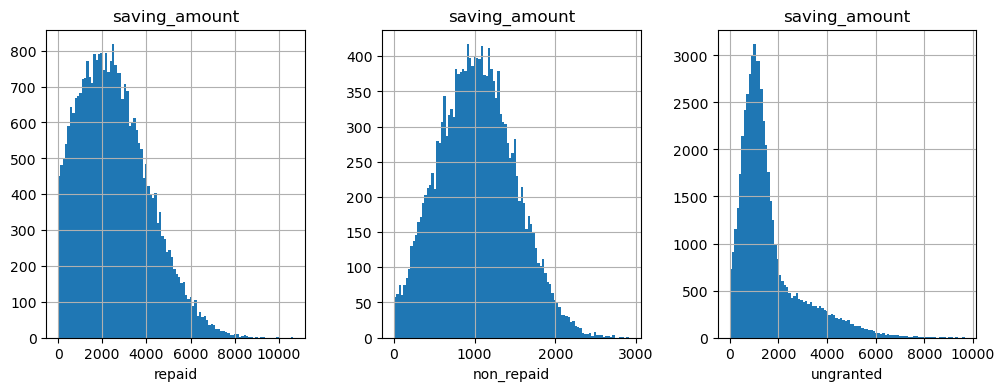

In [32]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('saving_amount', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('saving_amount', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('saving_amount', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [33]:
print(f'Average saving_amount by repaid group: {repaid["saving_amount"].median()}')
print(f'Average saving_amount by non-repaid group: {non_repaid["saving_amount"].median()}')
print(f'Average saving_amount by ungranted group: {ungranted["saving_amount"].median()}')

Average saving_amount by repaid group: 2399.0
Average saving_amount by non-repaid group: 1019.0
Average saving_amount by ungranted group: 1216.0


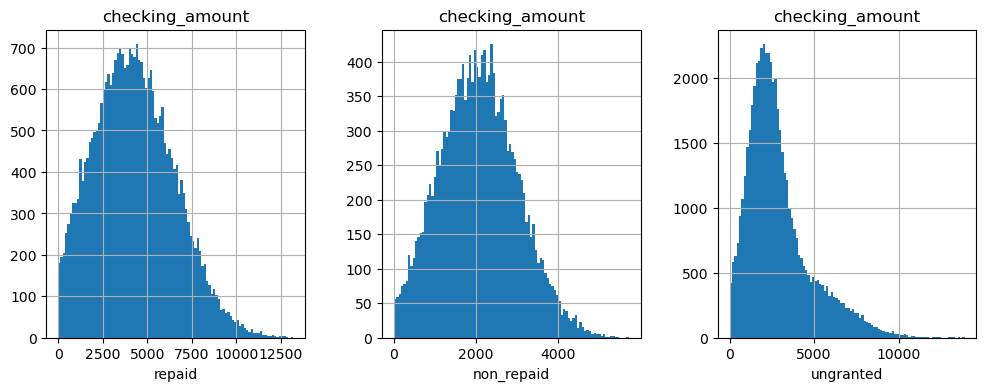

In [34]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('checking_amount', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('checking_amount', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('checking_amount', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [35]:
print(f'Average checking_amount by repaid group: {repaid["checking_amount"].median()}')
print(f'Average checking_amount by non-repaid group: {non_repaid["checking_amount"].median()}')
print(f'Average checking_amount by ungranted group: {ungranted["checking_amount"].median()}')

Average checking_amount by repaid group: 4160.5
Average checking_amount by non-repaid group: 2042.0
Average checking_amount by ungranted group: 2442.0


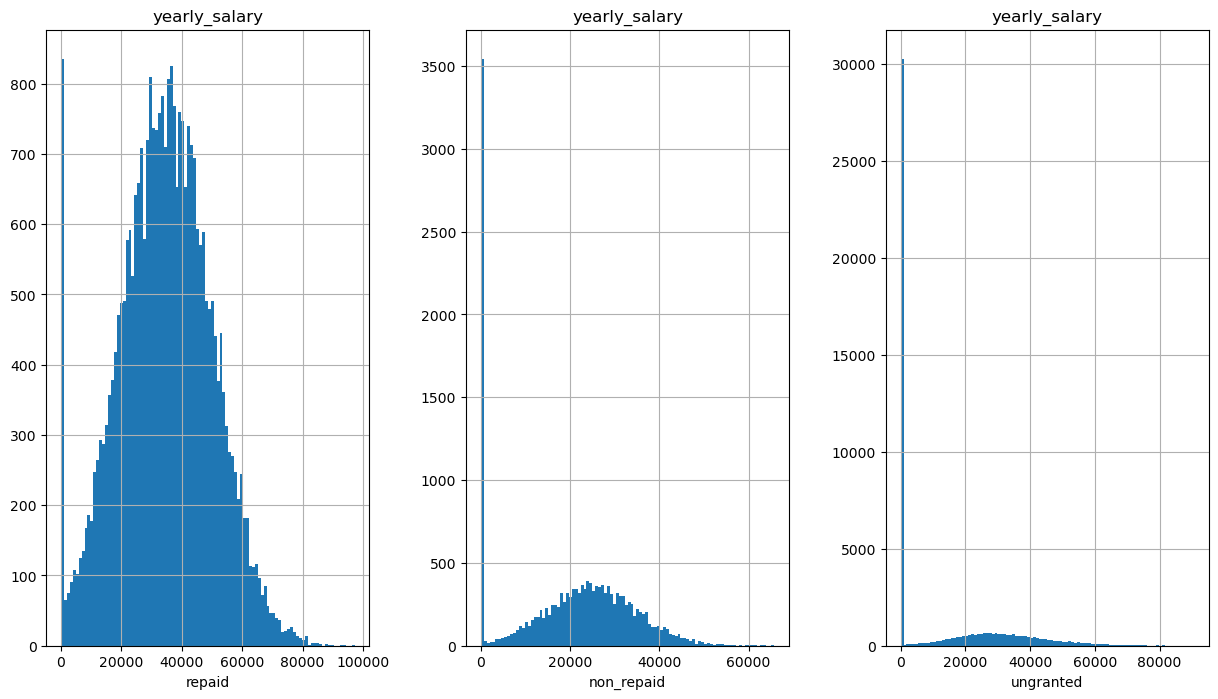

In [36]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(15, 8)

repaid.hist('yearly_salary', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('yearly_salary', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('yearly_salary', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [37]:
print(f'Average yearly_salary by repaid group: {repaid["yearly_salary"].median()}')
print(f'Average yearly_salary by non-repaid group: {non_repaid["yearly_salary"].median()}')
print(f'Average yearly_salary by ungranted group: {ungranted["yearly_salary"].median()}')

Average yearly_salary by repaid group: 34600.0
Average yearly_salary by non-repaid group: 21700.0
Average yearly_salary by ungranted group: 0.0


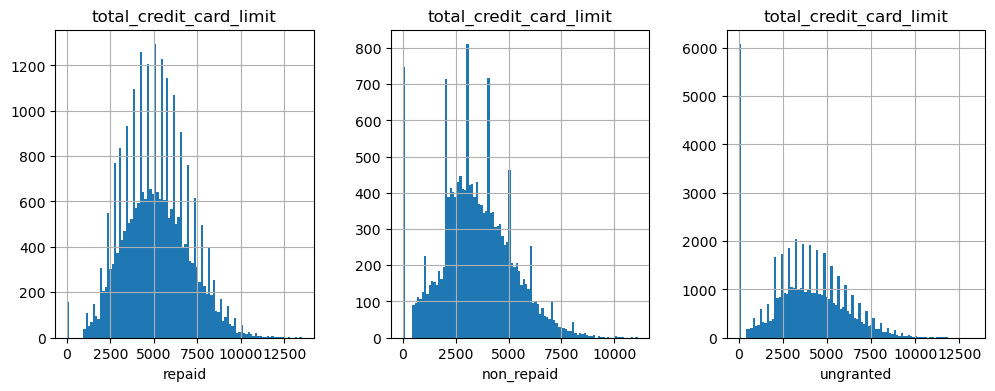

In [38]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('total_credit_card_limit', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('total_credit_card_limit', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('total_credit_card_limit', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [39]:
print(f'Average total_credit_card_limit by repaid group: {repaid["total_credit_card_limit"].median()}')
print(f'Average total_credit_card_limit by non-repaid group: {non_repaid["total_credit_card_limit"].median()}')
print(f'Average total_credit_card_limit by ungranted group: {ungranted["total_credit_card_limit"].median()}')

Average total_credit_card_limit by repaid group: 5000.0
Average total_credit_card_limit by non-repaid group: 3400.0
Average total_credit_card_limit by ungranted group: 3700.0


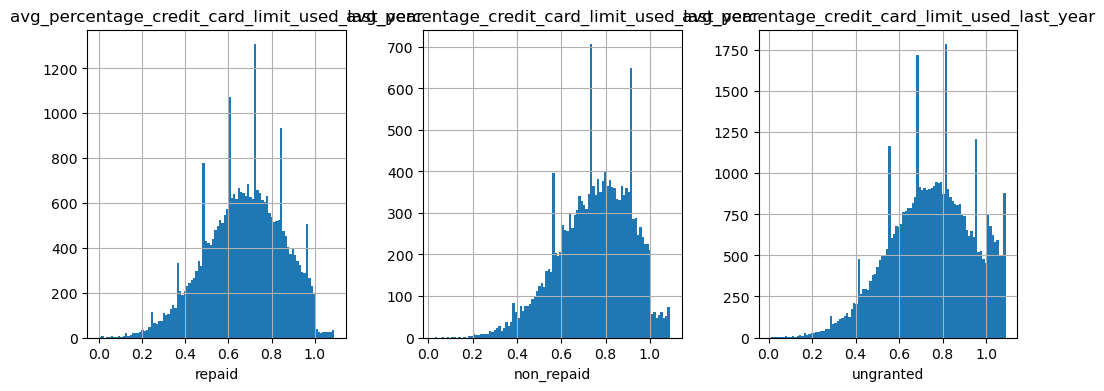

In [40]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('avg_percentage_credit_card_limit_used_last_year', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('avg_percentage_credit_card_limit_used_last_year', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('avg_percentage_credit_card_limit_used_last_year', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [41]:
print(repaid['avg_percentage_credit_card_limit_used_last_year'].median())
print(non_repaid['avg_percentage_credit_card_limit_used_last_year'].median())
print(ungranted['avg_percentage_credit_card_limit_used_last_year'].median())

0.68
0.77
0.76


In [42]:
#Check the values of loan_granted and loan_repaid
print(df_loan['loan_granted'].unique())
print(df_loan['loan_repaid'].unique())

print('--'*10)

print(df_loan.loc[df_loan.loan_granted ==0 ]['loan_repaid'].unique())
print(df_loan.loc[df_loan.loan_granted ==1 ]['loan_repaid'].unique())

[0 1]
[nan  1.  0.]
--------------------
[nan]
[1. 0.]


In [43]:
#Create the target: loan_quality
df_loan.loc[((df_loan['loan_granted'] == 1) & (df_loan['loan_repaid'] == 1)), 'loan_quality'] = 0
df_loan.loc[((df_loan['loan_granted'] == 1) & (df_loan['loan_repaid'] == 0)), 'loan_quality'] = 1
df_loan.loc[(df_loan['loan_granted'] == 0), 'loan_quality'] = -1

print(df_loan['loan_quality'].unique())

print('--'*10)

print(df_loan.loc[(df_loan['loan_granted']==1)&(df_loan['loan_repaid']==1)]['loan_quality'].unique())
print(df_loan.loc[(df_loan['loan_granted']==1)&(df_loan['loan_repaid']==0)]['loan_quality'].unique())
print(df_loan.loc[(df_loan['loan_granted']==0)]['loan_quality'].unique())

[-1.  0.  1.]
--------------------
[0.]
[1.]
[-1.]




    Target is created according to a risk framework for model building.
        If loan is granted and not paid -> risk, mark it 1

        If loan is granted and paid -> risk, mark it 0

        for all the ungranted loans, -1 is just an indicator. Mathematical calculation will be different for business situation



## **Data Preprocessing & Engineering**

In [44]:
# Create a copy of the loan dataset for feature transformation
df_loan_tr = df_loan.copy()

In [45]:
# Create new feature

# Cast the datatype of "date" field

df_loan_tr['date']= pd.to_datetime(df_loan_tr['date'])
df_loan_tr['date'].dtypes


# Year from date
df_loan_tr['year'] = df_loan_tr['date'].dt.year

# Month from date
df_loan_tr['month'] = df_loan_tr['date'].dt.month

# Day from date
df_loan_tr['day'] = df_loan_tr['date'].dt.day

# Quarter from date
df_loan_tr['quarter'] = df_loan_tr['date'].dt.quarter

# Semester from date
df_loan_tr['semester'] = np.where(df_loan_tr.quarter.isin([1,2]),1,2)

# Day of the week from date
df_loan_tr['dayofweek'] = df_loan_tr['date'].dt.dayofweek

df_loan_tr[['date', 'year', 'month', 'day', 'quarter', 'semester', 'dayofweek']].head()

,date,year,month,day,quarter,semester,dayofweek
0,2012-03-15,2012,3,15,1,1,3
1,2012-01-17,2012,1,17,1,1,1
2,2012-02-09,2012,2,9,1,1,3
3,2012-06-27,2012,6,27,2,1,2
4,2012-05-21,2012,5,21,2,1,0


In [46]:
# Check the unique day of week
df_loan_tr['dayofweek'].unique()

array([3, 1, 2, 0, 4])

### **Encode**

In [47]:
# Unique values in loan_purpose

df_loan_tr["loan_purpose"].unique()

array(['investment', 'other', 'business', 'emergency_funds', 'home'],
      dtype=object)

In [48]:
# Convert the datatypes of the feature to 'category' before Label encoding.
df_loan_tr["loan_purpose"] = df_loan_tr["loan_purpose"].astype('category')

# Label Encoding
df_loan_tr["loan_purpose_cat"] = df_loan_tr["loan_purpose"].cat.codes

df_loan_tr[["loan_purpose", "loan_purpose_cat"]].head(3)

,loan_purpose,loan_purpose_cat
0,investment,3
1,investment,3
2,other,4


In [49]:
# Calculate missing value count and percentage

missing_value_df_loan_tr = pd.DataFrame(index = df_loan_tr.keys(), data =df_loan_tr.isnull().sum(), columns = ['Missing_Value_Count'])

missing_value_df_loan_tr['Missing_Value_Percentage'] = np.round(((df_loan_tr.isnull().mean())*100),2)

missing_value_df_loan_tr.sort_values('Missing_Value_Count',ascending= False)

,Missing_Value_Count,Missing_Value_Percentage
fully_repaid_previous_loans,54947,54.35
currently_repaying_other_loans,54947,54.35
loan_repaid,53446,52.86
avg_percentage_credit_card_limit_used_last_year,6972,6.90
loan_id,0,0.00
age,0,0.00
dayofweek,0,0.00
semester,0,0.00
quarter,0,0.00
day,0,0.00


### **Imputation**

In [50]:
print(df_loan_tr['fully_repaid_previous_loans'].unique())

print(df_loan_tr.loc[df_loan_tr['fully_repaid_previous_loans'].isnull()]['is_first_loan'].unique())

# Impute fully_repaid_previous_loans with some numerical values for all the first loans

[nan  1.  0.]
[1]


In [51]:
print(df_loan_tr['currently_repaying_other_loans'].unique())

print(df_loan_tr.loc[df_loan_tr['currently_repaying_other_loans'].isnull()]['is_first_loan'].unique())

# Impute currently_repaying_other_loans with some numerical values for all the first loans

[nan  0.  1.]
[1]


In [52]:
# print(df_loan_tr['avg_percentage_credit_card_limit_used_last_year'].unique())

print(df_loan_tr.loc[df_loan_tr['avg_percentage_credit_card_limit_used_last_year'].isnull()]['total_credit_card_limit'].unique())

print(df_loan_tr.loc[df_loan_tr['total_credit_card_limit']==0]['avg_percentage_credit_card_limit_used_last_year'].unique())

[0]
[nan]


In [53]:
# replace null with -1

df_loan_tr['fully_repaid_previous_loans'].fillna(-1, inplace=True)

df_loan_tr['currently_repaying_other_loans'].fillna(-1, inplace=True)

df_loan_tr['avg_percentage_credit_card_limit_used_last_year'].fillna(-1, inplace=True)

### **Feature Selection**

In [54]:
feature_set = [
    'saving_amount',
    'checking_amount',
    'yearly_salary',
    'total_credit_card_limit',
    'currently_repaying_other_loans',
    'is_employed',
    'avg_percentage_credit_card_limit_used_last_year',
    'dependent_number',
    'age',
    'loan_purpose_cat',
    'fully_repaid_previous_loans',]

In [55]:
## Train and test on granted loans

granted_loan = df_loan_tr.loc[(df_loan_tr['loan_quality'] == 1) | (df_loan_tr['loan_quality'] == 0)]

print(f'#loan_id: {granted_loan.shape[0]} ')

#loan_id: 47654 


In [56]:
# Cross check Target values

print('cross check the target values')

print('--'*15)

print(granted_loan['loan_quality'].unique())
print(granted_loan['loan_granted'].unique())
print(granted_loan['loan_repaid'].unique())

cross check the target values
------------------------------
[0. 1.]
[1]
[1. 0.]


In [57]:
## Predict / Score Population on ungranted loans

ungranted_loan = df_loan_tr.loc[(df_loan_tr['loan_quality'] == -1)]

print(f'#loan_id: {ungranted_loan.shape[0]} ')

#loan_id: 53446 


In [58]:
print('cross check the target values')

print('--'*15)

print(ungranted_loan['loan_quality'].unique())
print(ungranted_loan['loan_granted'].unique())
print(ungranted_loan['loan_repaid'].unique())

cross check the target values
------------------------------
[-1.]
[0]
[nan]


## **Train & Test Preparation**

In [59]:
train_granted = granted_loan.loc[~(granted_loan['month'].isin([1,2,3]))]
exog_train_granted = train_granted[feature_set]
endog_train_granted = train_granted['loan_quality']

print(train_granted.shape)

(35609, 24)


In [60]:
# Insample train and validation split

from sklearn.model_selection import cross_val_score, train_test_split

x_train, x_val, y_train, y_val = train_test_split(exog_train_granted, endog_train_granted, test_size=0.1, random_state=42)

In [61]:
# Test data

test_granted = granted_loan.loc[(granted_loan['month'].isin([1,2,3]))]
exog_test = test_granted[feature_set]

print(test_granted.shape)

(12045, 24)


In [62]:
test_granted['loan_quality'].unique()

array([0., 1.])

## **Data Scaling**

In [63]:
#Data Scaling
'''
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
exog_test = scaler.transform(exog_test)
'''

'\nfrom sklearn.preprocessing import MinMaxScaler\n\nscaler = MinMaxScaler()\nx_train = scaler.fit_transform(x_train)\nexog_test = scaler.transform(exog_test)\n'

In [64]:
'''
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
exog_test = scaler.transform(exog_test)
'''

'\nfrom sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nx_train = scaler.fit_transform(x_train)\nexog_test = scaler.transform(exog_test)\n'

## **Modelling**

## 1. Random Forest

In [65]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state = 42)

In [66]:
# Parameters used by the current forest

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [67]:
base_model_rf = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state = 42)
base_model_rf.fit(x_train, y_train)
base_accuracy_rf = get_rocauc(base_model_rf, x_val, y_val)

Model Performance:
----------
----------
ROC = 0.97%


In [68]:
y_train_pred_rf = base_model_rf.predict(x_train)
print(classification_report(y_train, y_train_pred_rf))

# Perform cross-validation to evaluate performance on the training data
# Define the number of folds for cross-validation (e.g., 5-fold cross-validation)
num_folds = 10

# Calculate cross-validated accuracy scores using cross_val_score
cv_scores_rf = cross_val_score(base_model_rf, x_train, y_train, cv=num_folds)

# Print the cross-validated accuracy scores and their mean
print("Cross-validated Accuracy Scores:", cv_scores_rf)
print("Mean Accuracy:", cv_scores_rf.mean())

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     20634
         1.0       0.89      0.94      0.91     11414

    accuracy                           0.94     32048
   macro avg       0.93      0.94      0.93     32048
weighted avg       0.94      0.94      0.94     32048

Cross-validated Accuracy Scores: [0.91981279 0.91513261 0.91731669 0.92355694 0.91669267 0.92355694
 0.91825273 0.92230889 0.92821473 0.90948814]
Mean Accuracy: 0.9194333136621344


In [69]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Calculate Root Mean Squared Error
rf_rmse = root_mean_squared_error(y_train, base_model_rf.predict(x_train))

print("Root Mean Squared Error Scores:", rf_rmse)



Root Mean Squared Error Scores: 0.2495002493753112


In [70]:
# Compute cross-validated AUC scores for the training set: cv_auc
cv_auc_rf = cross_val_score(base_model_rf, x_train, y_train, cv=10, scoring = 'roc_auc')

# Print list of AUC scores
print("AUC scores computed using 10-fold cross-validation: {}".format(cv_auc_rf))

AUC scores computed using 10-fold cross-validation: [0.97544484 0.97349157 0.97358923 0.97634461 0.97484705 0.9770398
 0.97635472 0.97705975 0.977323   0.96883108]


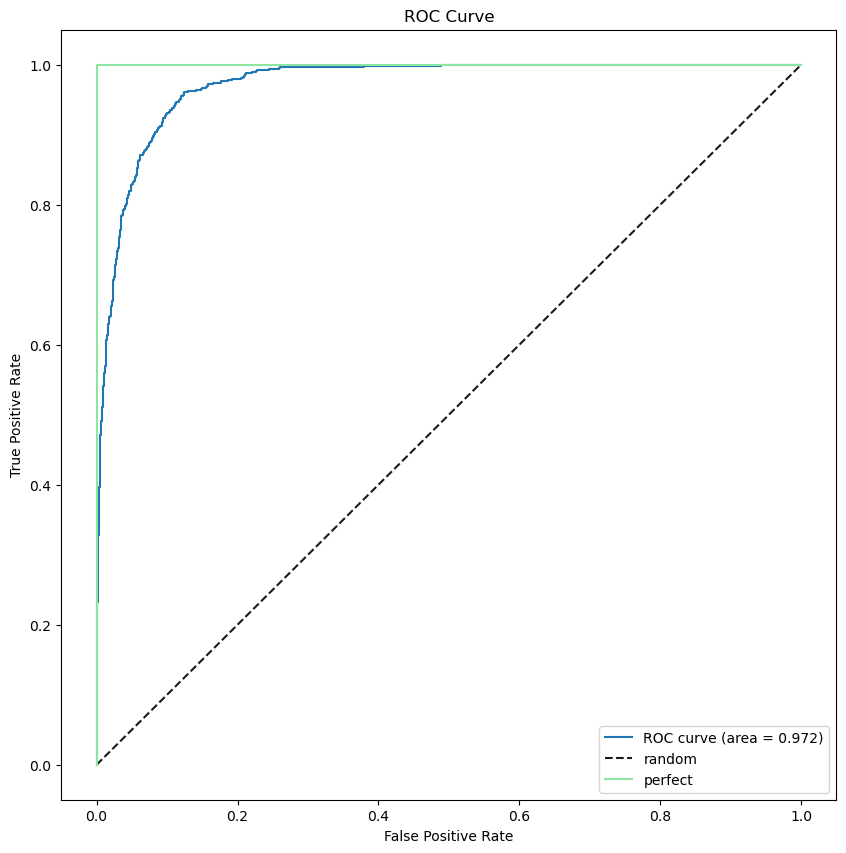

In [71]:
# Plot ROC curve
y_pred_proba_rf = base_model_rf.predict_proba(x_val)[:, 1]
plot_roc(y_val, y_pred_proba_rf)

###**Influencing Features**

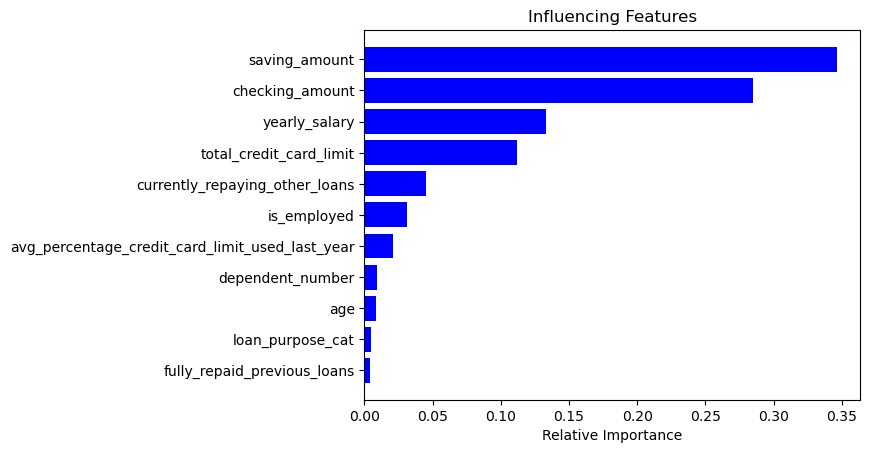

In [72]:
features = exog_train_granted.columns
importances = base_model_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Influencing Features')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

####**Clear feature RF**

In [73]:
# List of top 6 features based on the importance graph
top_features = [
    'saving_amount',
    'checking_amount',
    'yearly_salary',
    'total_credit_card_limit',
    'currently_repaying_other_loans',
    'is_employed',
    'avg_percentage_credit_card_limit_used_last_year',
    'dependent_number',
    'age',
    'loan_purpose_cat',
    'fully_repaid_previous_loans',
]

# Select only the top features from the dataset
exog_train_granted_top = exog_train_granted[top_features]

# Train and validation split
x_train, x_val, y_train, y_val = train_test_split(
    exog_train_granted_top,
    endog_train_granted,
    test_size=0.1,
    random_state=42
)

rf = RandomForestClassifier(random_state = 42)
base_model_rf = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state = 42)
base_model_rf.fit(x_train, y_train)
base_accuracy_rf = get_rocauc(base_model_rf, x_val, y_val)

Model Performance:
----------
----------
ROC = 0.97%


In [74]:
from sklearn.metrics import classification_report

y_train_pred_rf = base_model_rf.predict(x_train)
print(classification_report(y_train, y_train_pred_rf))

# Perform cross-validation to evaluate performance on the training data
# Define the number of folds for cross-validation (e.g., 5-fold cross-validation)
num_folds = 10

# Calculate cross-validated accuracy scores using cross_val_score
cv_scores_rf = cross_val_score(base_model_rf, x_train, y_train, cv=num_folds)

# Print the cross-validated accuracy scores and their mean
print("Cross-validated Accuracy Scores:", cv_scores_rf)
print("Mean Accuracy:", cv_scores_rf.mean())

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     20634
         1.0       0.89      0.94      0.91     11414

    accuracy                           0.94     32048
   macro avg       0.93      0.94      0.93     32048
weighted avg       0.94      0.94      0.94     32048

Cross-validated Accuracy Scores: [0.91981279 0.91513261 0.91731669 0.92355694 0.91669267 0.92355694
 0.91825273 0.92230889 0.92821473 0.90948814]
Mean Accuracy: 0.9194333136621344


In [80]:
from sklearn.metrics import root_mean_squared_error

# Predict on the training data to evaluate RMSE
y_train_pred = base_model_rf.predict(x_train)

# Calculate RMSE
rmse_rf = root_mean_squared_error(y_train, y_train_pred)
print("Root Mean Squared Error (RMSE):", rmse_rf)

Root Mean Squared Error (RMSE): 0.2495002493753112


###**Parameter Tuning**

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

param_distributions = {
    'n_estimators': [100, 200],  # Fewer trees for faster computation
    'max_depth': [10, 20],  # Limit depth options to reduce complexity
    'min_samples_split': [2, 5],  # Focus on typical values for splitting
    'min_samples_leaf': [1, 2],  # Fewer options for leaf size
    'max_features': ['sqrt'],  # Use 'sqrt' as it is a common choice for Random Forest
    'bootstrap': [True],  # Focus on bootstrap sampling
    'criterion': ['gini', 'entropy'],  # Include both criteria but reduce other options
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV for Random Forest tuning
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=32,  # Match the number of parameter combinations
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Evaluate using accuracy
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the random search on the training data
random_search_rf.fit(x_train, y_train)

# Get the best parameters and score
print("Best Parameters:", random_search_rf.best_params_)
print("Best Accuracy:", random_search_rf.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': True}
Best Accuracy: 0.9208686977741424


In [81]:
from sklearn.metrics import root_mean_squared_error

# Predict on the training data to evaluate RMSE
y_train_pred = random_search_rf.predict(x_train)

# Calculate RMSE
rmse_rf = root_mean_squared_error(y_train, y_train_pred)
print("Root Mean Squared Error (RMSE):", rmse_rf)

Root Mean Squared Error (RMSE): 0.14098381235794247


##**Best Tune Model**

In [82]:
# Summary of model performance
model_performance = {
    'Model 2: Random Forest': {'Best Accuracy': 0.9209, 'RMSE': 0.1410},
    'Model 3: Logistic Regression': {'Best Accuracy': 0.9001, 'RMSE': 0.3164},
    'Model 4: SVM': {'Best Accuracy': 0.9004, 'RMSE': 0.3127},
    'Model 5: CatBoost': {'Best Accuracy': 0.9241, 'RMSE': 0.2643},
    'Model 6: Decision Tree + AdaBoost': {'Best Accuracy': 0.9192, 'RMSE': 0.2776},
}

# Find the model with the highest accuracy
best_accuracy_model = max(model_performance, key=lambda x: model_performance[x]['Best Accuracy'])
best_accuracy_score = model_performance[best_accuracy_model]['Best Accuracy']

# Find the model with the lowest RMSE
best_rmse_model = min(model_performance, key=lambda x: model_performance[x]['RMSE'])
best_rmse_value = model_performance[best_rmse_model]['RMSE']

print(f"Model with the best accuracy: {best_accuracy_model} (Accuracy: {best_accuracy_score})")
print(f"Model with the best RMSE: {best_rmse_model} (RMSE: {best_rmse_value})")

# To decide the best model overall, we could prioritize accuracy, RMSE, or consider both metrics.
# Here, you can define the criteria based on your priority:
if best_accuracy_model == best_rmse_model:
    print(f"The overall best model is: {best_accuracy_model}")
else:
    print(f"Model with highest accuracy: {best_accuracy_model} (Accuracy: {best_accuracy_score})")
    print(f"Model with lowest RMSE: {best_rmse_model} (RMSE: {best_rmse_value})")
    # Further analysis might be needed to choose the best model depending on the context.


Model with the best accuracy: Model 5: CatBoost (Accuracy: 0.9241)
Model with the best RMSE: Model 2: Random Forest (RMSE: 0.141)
Model with highest accuracy: Model 5: CatBoost (Accuracy: 0.9241)
Model with lowest RMSE: Model 2: Random Forest (RMSE: 0.141)


##Finalize

In [83]:
from sklearn.ensemble import RandomForestClassifier

# Best parameters from the tuning process
best_rf_params = {
    'n_estimators': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 20,
    'criterion': 'gini',
    'bootstrap': True,
    'random_state': 42
}

# Initialize the model with the best parameters
best_rf_model = RandomForestClassifier(**best_rf_params)

# Fit the model on the entire training set
best_rf_model.fit(x_train, y_train)


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

##Evaluation

In [85]:
from sklearn.metrics import accuracy_score, root_mean_squared_error

# Predict on the test set
y_test_pred = best_rf_model.predict(exog_test)

# Assuming y_test is the true labels for the test set
y_test = test_granted['loan_quality']  # Extract the true labels

# Calculate accuracy and RMSE on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test RMSE: {test_rmse}")




Test Accuracy: 0.9187214611872146
Test RMSE: 0.28509391226889674


##**Cross-Validation Final Model**

In [86]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = (-cv_scores) ** 0.5

print(f"Cross-Validated RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")


Cross-Validated RMSE: 0.284010865986704 ± 0.005411512079480795


In [87]:
import joblib

# Save the trained model to a file
joblib.dump(best_rf_model, "best_rf_model.pkl")



['best_rf_model.pkl']